# One step forecast

In [2]:
# Requirements
import optuna
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import warnings
from scipy.stats import norm

# Suppress Optuna's experimental warning for MedianPruner
warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning)

C:\Users\DAIICT I\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# -----------------------
# 0) Housekeeping
# -----------------------
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Ensure deterministic behavior (slower but stable)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [14]:
# ----------------------------------------------------------------------------
# 1. Configuration Grid
# ----------------------------------------------------------------------------
class Config:
    """Centralized configuration for hyperparameters and settings."""
    # --- Data and Splitting ---
    FILE_PATH = r"C:\Users\DAIICT I\Desktop\Msc DS Sujal 202418017\Interval_Forecast_Multivariate\merged_df_final.csv"
    TARGET_COLUMN = 'Carbon_Price_USD'
    DATE_COLUMN = 'Date'
    VAL_SPLIT_DATE = '2024-04-01'
    
    # --- Optuna Hyperparameter Search Space ---
    N_TRIALS = 100  # Number of optimization trials
    WINDOW_SIZE_MIN = 2
    WINDOW_SIZE_MAX = 40
    RNN_HIDDEN_SIZES = [32, 64, 128]
    NUM_GAUSSIANS_MIN = 2
    NUM_GAUSSIANS_MAX = 8
    NUM_RNN_LAYERS_MIN = 1
    NUM_RNN_LAYERS_MAX = 3
    DROPOUT_MIN = 0.0
    DROPOUT_MAX = 0.4
    LR_MIN = 1e-4
    LR_MAX = 1e-2

    # --- Final Training and Evaluation ---
    NUM_RUNS = 5  # Number of ensemble runs for stability check
    MAX_EPOCHS = 100
    BATCH_SIZE = 32
    CRPS_SAMPLES = 1000 # Number of samples for CRPS calculation

    # --- Prediction Interval Configuration (CHANGE THIS SECTION) ---
    # For a standard 95% symmetric interval: [0.025, 0.975]
    # For an asymmetric 95% interval: [0.04, 0.99] or [0.01, 0.96] etc.
    LOWER_QUANTILE = 0.025
    UPPER_QUANTILE = 0.975

In [15]:
# ----------------------------------------------------------------------------
# 2. Device Configuration
# ----------------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [16]:
# ----------------------------------------------------------------------------
# 3. RnnMDN Model Definition
# ----------------------------------------------------------------------------
class RnnMDN(nn.Module):
    """RNN (Vanilla) base with a Mixture Density Network head."""
    def __init__(self, input_size, rnn_hidden_size, num_rnn_layers, num_gaussians, dropout):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=rnn_hidden_size,
            num_layers=num_rnn_layers,
            batch_first=True,
            dropout=dropout if num_rnn_layers > 1 else 0
        )
        self.z_pi = nn.Linear(rnn_hidden_size, num_gaussians)
        self.z_sigma = nn.Linear(rnn_hidden_size, num_gaussians)
        self.z_mu = nn.Linear(rnn_hidden_size, num_gaussians)

    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        last_output = rnn_out[:, -1, :]
        pi = F.softmax(self.z_pi(last_output), dim=1)
        sigma = F.softplus(self.z_sigma(last_output)) + 1e-6
        mu = self.z_mu(last_output)
        return pi, sigma, mu


In [17]:
# ----------------------------------------------------------------------------
# 4. Helper Functions
# ----------------------------------------------------------------------------
def create_sequences(features, target, window_size):
    """Creates sequences for true forecasting."""
    X_seq, y_seq = [], []
    for i in range(len(features) - window_size):
        X_seq.append(features[i:(i + window_size)])
        y_seq.append(target[i + window_size])
    return np.array(X_seq), np.array(y_seq)

def mdn_loss(pi, sigma, mu, y):
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    log_prob = m.log_prob(y)
    weighted_log_prob = log_prob + torch.log(pi)
    log_sum_exp = torch.logsumexp(weighted_log_prob, dim=1)
    return -torch.mean(log_sum_exp)

def calculate_all_metrics(pi, sigma, mu, y_true_tensor, scaler_y, lower_quantile, upper_quantile, num_samples_crps):
    """Calculates PICP, MPIW, CRPS, and prediction bounds from MDN parameters."""
    with torch.no_grad():
        # --- PICP and MPIW Calculation ---
        effective_mu = torch.sum(pi * mu, dim=1)
        effective_var = torch.sum(pi * (sigma**2 + mu**2), dim=1) - effective_mu**2
        effective_sigma = torch.sqrt(effective_var + 1e-6)

        z_lower = norm.ppf(lower_quantile)
        z_upper = norm.ppf(upper_quantile)

        lower_scaled = effective_mu + z_lower * effective_sigma
        upper_scaled = effective_mu + z_upper * effective_sigma

        y_true_inv = scaler_y.inverse_transform(y_true_tensor.cpu().numpy()).flatten()
        lower_inv = scaler_y.inverse_transform(lower_scaled.cpu().numpy().reshape(-1, 1)).flatten()
        upper_inv = scaler_y.inverse_transform(upper_scaled.cpu().numpy().reshape(-1, 1)).flatten()
        
        is_inside = (y_true_inv >= lower_inv) & (y_true_inv <= upper_inv)
        picp = np.mean(is_inside) * 100
        mpiw = np.mean(upper_inv - lower_inv)

        # --- CRPS Calculation ---
        component_indices_1 = torch.multinomial(pi, num_samples_crps, replacement=True)
        mu_samples_1 = torch.gather(mu, 1, component_indices_1)
        sigma_samples_1 = torch.gather(sigma, 1, component_indices_1)
        samples_1 = torch.normal(mu_samples_1, sigma_samples_1).cpu().numpy()

        component_indices_2 = torch.multinomial(pi, num_samples_crps, replacement=True)
        mu_samples_2 = torch.gather(mu, 1, component_indices_2)
        sigma_samples_2 = torch.gather(sigma, 1, component_indices_2)
        samples_2 = torch.normal(mu_samples_2, sigma_samples_2).cpu().numpy()

        samples_inv_1 = scaler_y.inverse_transform(samples_1)
        samples_inv_2 = scaler_y.inverse_transform(samples_2)
        
        term1 = np.mean(np.abs(samples_inv_1 - y_true_inv.reshape(-1, 1)), axis=1)
        term2 = 0.5 * np.mean(np.abs(samples_inv_1 - samples_inv_2), axis=1)
        crps = np.mean(term1 - term2)

        return mpiw, picp, crps, lower_inv, upper_inv

In [18]:
# ----------------------------------------------------------------------------
# 5. Data Loading and Preprocessing
# ----------------------------------------------------------------------------
df = pd.read_csv(Config.FILE_PATH)
df[Config.DATE_COLUMN] = pd.to_datetime(df[Config.DATE_COLUMN])
df = df.sort_values(Config.DATE_COLUMN).fillna(method='ffill').reset_index(drop=True)

feature_cols = df.columns.drop([Config.DATE_COLUMN])

train_val_df = df[df[Config.DATE_COLUMN] < Config.VAL_SPLIT_DATE]
test_df = df[df[Config.DATE_COLUMN] >= Config.VAL_SPLIT_DATE]
val_split_index = int(len(train_val_df) * 0.9)
train_df = train_val_df[:val_split_index]
val_df = train_val_df[val_split_index:]

X_train_raw, y_train_raw = train_df[feature_cols].values, train_df[Config.TARGET_COLUMN].values.reshape(-1, 1)
X_val_raw, y_val_raw = val_df[feature_cols].values, val_df[Config.TARGET_COLUMN].values.reshape(-1, 1)
X_test_raw, y_test_raw = test_df[feature_cols].values, test_df[Config.TARGET_COLUMN].values.reshape(-1, 1)

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_x.fit_transform(X_train_raw)
y_train = scaler_y.fit_transform(y_train_raw)
X_val = scaler_x.transform(X_val_raw)
y_val = scaler_y.transform(y_val_raw)
X_test = scaler_x.transform(X_test_raw)
y_test = scaler_y.transform(y_test_raw)

C:\Users\DAIICT I\AppData\Local\Temp\ipykernel_25684\139681524.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.sort_values(Config.DATE_COLUMN).fillna(method='ffill').reset_index(drop=True)


In [19]:
# ----------------------------------------------------------------------------
# 6. Optuna Objective Function
# ----------------------------------------------------------------------------
def objective(trial):
    window_size = trial.suggest_int('window_size', Config.WINDOW_SIZE_MIN, Config.WINDOW_SIZE_MAX)
    num_rnn_layers = trial.suggest_int('num_rnn_layers', Config.NUM_RNN_LAYERS_MIN, Config.NUM_RNN_LAYERS_MAX)
    rnn_hidden_size = trial.suggest_categorical('rnn_hidden_size', Config.RNN_HIDDEN_SIZES)
    num_gaussians = trial.suggest_int('num_gaussians', Config.NUM_GAUSSIANS_MIN, Config.NUM_GAUSSIANS_MAX)
    dropout = trial.suggest_float('dropout', Config.DROPOUT_MIN, Config.DROPOUT_MAX)
    lr = trial.suggest_float('lr', Config.LR_MIN, Config.LR_MAX, log=True)

    X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
    X_val_seq, y_val_seq = create_sequences(X_val, y_val, window_size)

    if len(X_val_seq) == 0:
        raise optuna.exceptions.TrialPruned()

    X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val_seq, dtype=torch.float32).to(device)
    
    model = RnnMDN(
        input_size=X_train_seq.shape[2], rnn_hidden_size=rnn_hidden_size,
        num_rnn_layers=num_rnn_layers, num_gaussians=num_gaussians, dropout=dropout
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=Config.BATCH_SIZE, shuffle=True)

    for epoch in range(Config.MAX_EPOCHS):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pi, sigma, mu = model(xb)
            loss = mdn_loss(pi, sigma, mu, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            pi_val, sigma_val, mu_val = model(X_val_tensor)
            # We only need PICP and MPIW for the optimization score
            mpiw, picp, _, _, _ = calculate_all_metrics(
                pi_val, sigma_val, mu_val, y_val_tensor, scaler_y,
                lower_quantile=0.025, upper_quantile=0.975, # Fixed 95% for optimization
                num_samples_crps=100 # Use fewer samples for speed during optimization
            )
        
        target_coverage = 95.0
        score = 1000.0 + (target_coverage - picp) if picp < (target_coverage - 1.0) else mpiw
        
        trial.report(score, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
            
    return score

In [20]:
# ----------------------------------------------------------------------------
# 7. Run Hyperparameter Optimization
# ----------------------------------------------------------------------------
print(f"\n{'='*20} STARTING HYPERPARAMETER OPTIMIZATION {'='*20}")
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=Config.N_TRIALS)

best_params = study.best_params
optimal_epochs = study.best_trial.last_step + 1
best_window_size = best_params['window_size']

print("\n--- Optuna Study Complete ---")
print(f"Best Score (Validation): {study.best_value:.4f}")
print("Best Hyperparameters:", best_params)
print(f"Optimal epochs found: {optimal_epochs}")


[I 2025-08-23 21:33:36,990] A new study created in memory with name: no-name-8f8e3649-dbb5-4c86-b423-d52d3338492d



==================== STARTING HYPERPARAMETER OPTIMIZATION ====================


[I 2025-08-23 21:33:41,612] Trial 0 finished with value: 1006.1111111111111 and parameters: {'window_size': 12, 'num_rnn_layers': 3, 'rnn_hidden_size': 32, 'num_gaussians': 3, 'dropout': 0.15413362990778798, 'lr': 0.0004377776912786333}. Best is trial 0 with value: 1006.1111111111111.
[I 2025-08-23 21:33:46,006] Trial 1 finished with value: 15.502262115478516 and parameters: {'window_size': 20, 'num_rnn_layers': 3, 'rnn_hidden_size': 32, 'num_gaussians': 8, 'dropout': 0.31490067745433653, 'lr': 0.002810284042562319}. Best is trial 1 with value: 15.502262115478516.
[I 2025-08-23 21:33:50,394] Trial 2 finished with value: 1047.6315789473683 and parameters: {'window_size': 27, 'num_rnn_layers': 3, 'rnn_hidden_size': 32, 'num_gaussians': 7, 'dropout': 0.3252684390952004, 'lr': 0.00011269051096739282}. Best is trial 1 with value: 15.502262115478516.
[I 2025-08-23 21:33:54,665] Trial 3 finished with value: 1001.3291139240506 and parameters: {'window_size': 5, 'num_rnn_layers': 2, 'rnn_hidden


--- Optuna Study Complete ---
Best Score (Validation): 7.0755
Best Hyperparameters: {'window_size': 9, 'num_rnn_layers': 1, 'rnn_hidden_size': 32, 'num_gaussians': 4, 'dropout': 0.08943758575875912, 'lr': 0.0029597767641088017}
Optimal epochs found: 100


In [21]:
# ----------------------------------------------------------------------------
# 8. Train and Evaluate Ensemble with BEST Hyperparameters
# ----------------------------------------------------------------------------
all_run_results = []

X_full_train_raw = np.concatenate((X_train_raw, X_val_raw), axis=0)
y_full_train_raw = np.concatenate((y_train_raw, y_val_raw), axis=0)
X_full_train = scaler_x.transform(X_full_train_raw)
y_full_train = scaler_y.transform(y_full_train_raw)

X_full_train_seq, y_full_train_seq = create_sequences(X_full_train, y_full_train, best_window_size)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, best_window_size)

X_full_train_tensor = torch.tensor(X_full_train_seq, dtype=torch.float32)
y_full_train_tensor = torch.tensor(y_full_train_seq, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32).to(device)

train_loader = DataLoader(TensorDataset(X_full_train_tensor, y_full_train_tensor), batch_size=Config.BATCH_SIZE, shuffle=True)

for i in range(Config.NUM_RUNS):
    print(f"\n{'='*20} STARTING STABILITY RUN {i+1}/{Config.NUM_RUNS} {'='*20}")
    
    final_model = RnnMDN(
        input_size=X_full_train_seq.shape[2],
        rnn_hidden_size=best_params['rnn_hidden_size'],
        num_rnn_layers=best_params['num_rnn_layers'],
        num_gaussians=best_params['num_gaussians'],
        dropout=best_params['dropout']
    ).to(device)
    optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params['lr'])

    print(f"Training final model for {optimal_epochs} epochs...")
    for epoch in range(optimal_epochs):
        final_model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pi, sigma, mu = final_model(xb)
            loss = mdn_loss(pi, sigma, mu, yb)
            loss.backward()
            optimizer.step()

    print(f"Evaluating Run {i+1} on test set...")
    final_model.eval()
    with torch.no_grad():
        pi_test, sigma_test, mu_test = final_model(X_test_tensor)
        
        mpiw, picp, crps, lower, upper = calculate_all_metrics(
            pi_test, sigma_test, mu_test, y_test_tensor, scaler_y,
            lower_quantile=Config.LOWER_QUANTILE, 
            upper_quantile=Config.UPPER_QUANTILE,
            num_samples_crps=Config.CRPS_SAMPLES
        )
        coverage = (Config.UPPER_QUANTILE - Config.LOWER_QUANTILE) * 100
        print(f"  Interval [{Config.LOWER_QUANTILE}, {Config.UPPER_QUANTILE}] ({coverage:.1f}%) -> PICP: {picp:.2f}%, MPIW: {mpiw:.4f}, CRPS: {crps:.4f}")

    all_run_results.append({
        'run': i+1, 'mpiw': mpiw, 'picp': picp, 'crps': crps,
        'lower_bound': lower, 'upper_bound': upper, 'params': best_params
    })


==================== STARTING STABILITY RUN 1/5 ====================
Training final model for 100 epochs...
Evaluating Run 1 on test set...
  Interval [0.025, 0.975] (95.0%) -> PICP: 92.50%, MPIW: 6.8680, CRPS: 1.0255

==================== STARTING STABILITY RUN 2/5 ====================
Training final model for 100 epochs...
Evaluating Run 2 on test set...
  Interval [0.025, 0.975] (95.0%) -> PICP: 97.50%, MPIW: 8.9765, CRPS: 1.0439

==================== STARTING STABILITY RUN 3/5 ====================
Training final model for 100 epochs...
Evaluating Run 3 on test set...
  Interval [0.025, 0.975] (95.0%) -> PICP: 95.00%, MPIW: 7.4733, CRPS: 1.0212

==================== STARTING STABILITY RUN 4/5 ====================
Training final model for 100 epochs...
Evaluating Run 4 on test set...
  Interval [0.025, 0.975] (95.0%) -> PICP: 93.75%, MPIW: 7.4679, CRPS: 1.0814

==================== STARTING STABILITY RUN 5/5 ====================
Training final model for 100 epochs...
Evaluating Run 


==================== ANALYSIS ACROSS ALL 5 RUNS ====================

Best hyperparameters saved to 'RNN_MDN_Forecasting_best_hyperparameters.csv'

--- Results from Each Run (Interval: [0.025, 0.975]) ---
       mpiw   picp    crps
run                       
1    6.8680  92.50  1.0255
2    8.9765  97.50  1.0439
3    7.4733  95.00  1.0212
4    7.4679  93.75  1.0814
5    9.0567  97.50  1.0080

--- Statistical Summary ---
         mpiw     picp    crps
count  5.0000   5.0000  5.0000
mean   7.9685  95.2500  1.0360
std    0.9883   2.2361  0.0285
min    6.8680  92.5000  1.0080
25%    7.4679  93.7500  1.0212
50%    7.4733  95.0000  1.0255
75%    8.9765  97.5000  1.0439
max    9.0567  97.5000  1.0814

Generating and saving the summary plot...


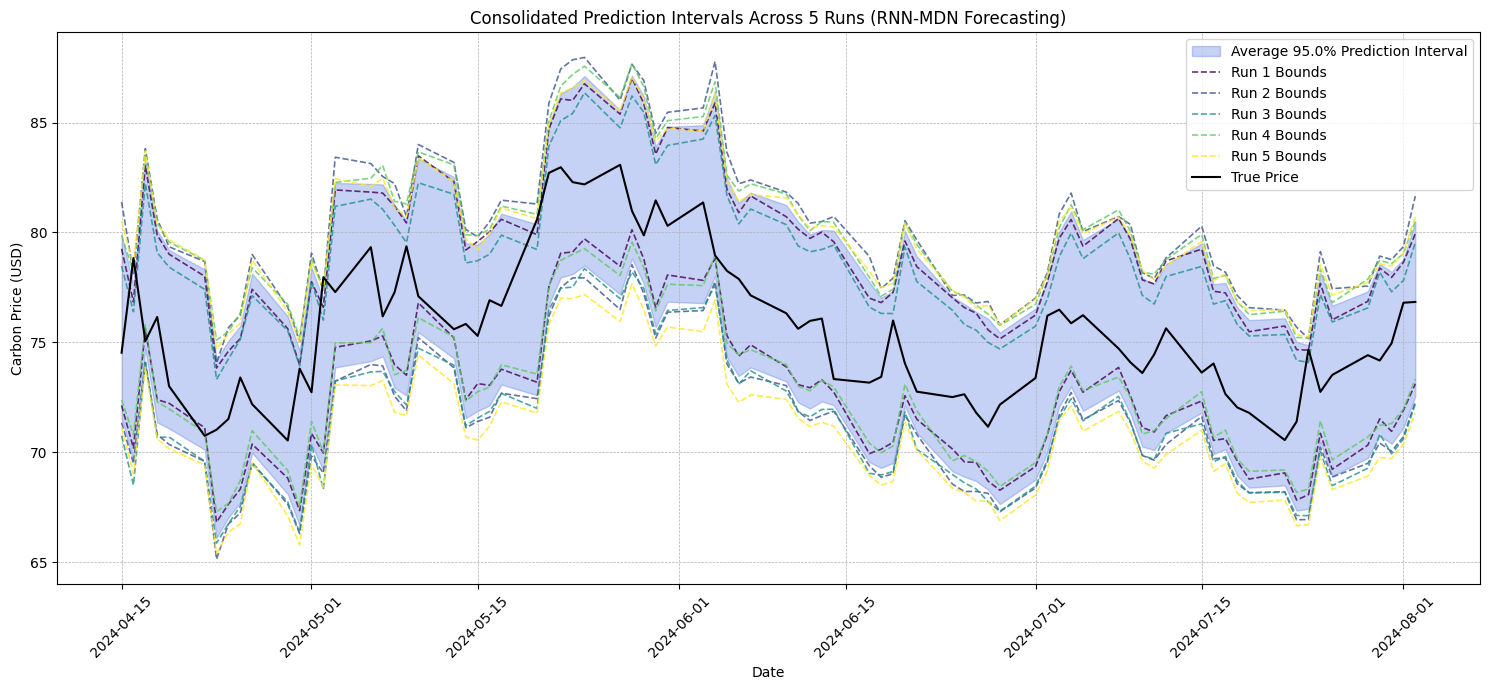


Summary plot saved to 'RNN_MDN_Forecasting_Multivariate.png'


In [22]:
# ----------------------------------------------------------------------------
# 9. FINAL ANALYSIS, SAVING, AND PLOTTING
# ----------------------------------------------------------------------------
print(f"\n{'='*20} ANALYSIS ACROSS ALL {Config.NUM_RUNS} RUNS {'='*20}")

params_df = pd.DataFrame([run['params'] for run in all_run_results])
params_df.insert(0, 'run', range(1, Config.NUM_RUNS + 1))
params_df.to_csv('RNN_MDN_Forecasting_best_hyperparameters.csv', index=False)
print("\nBest hyperparameters saved to 'RNN_MDN_Forecasting_best_hyperparameters.csv'")

metrics_df = pd.DataFrame(all_run_results).drop(columns=['params', 'lower_bound', 'upper_bound']).set_index('run')

print(f"\n--- Results from Each Run (Interval: [{Config.LOWER_QUANTILE}, {Config.UPPER_QUANTILE}]) ---")
print(metrics_df.round(4))

print("\n--- Statistical Summary ---")
print(metrics_df.describe().round(4))

print("\nGenerating and saving the summary plot...")
plt.figure(figsize=(15, 7))

lower_bounds = np.array([run['lower_bound'] for run in all_run_results])
upper_bounds = np.array([run['upper_bound'] for run in all_run_results])
avg_lower_bound = lower_bounds.mean(axis=0)
avg_upper_bound = upper_bounds.mean(axis=0)

plot_dates = test_df[Config.DATE_COLUMN].values[best_window_size:]
y_test_raw_plot = scaler_y.inverse_transform(y_test_seq)

coverage = (Config.UPPER_QUANTILE - Config.LOWER_QUANTILE) * 100
plt.fill_between(
    plot_dates, avg_lower_bound, avg_upper_bound, 
    color='royalblue', alpha=0.3, label=f'Average {coverage:.1f}% Prediction Interval'
)

colors = plt.cm.viridis(np.linspace(0, 1, Config.NUM_RUNS))
for run_index, run_data in enumerate(all_run_results):
    plt.plot(plot_dates, run_data['lower_bound'], color=colors[run_index], linestyle='--', linewidth=1.2, alpha=0.8)
    plt.plot(plot_dates, run_data['upper_bound'], color=colors[run_index], linestyle='--', linewidth=1.2, alpha=0.8, label=f'Run {run_index+1} Bounds')

plt.plot(plot_dates, y_test_raw_plot, color='black', linewidth=1.5, label='True Price')

plt.title(f'Consolidated Prediction Intervals Across {Config.NUM_RUNS} Runs (RNN-MDN Forecasting)')
plt.xlabel('Date')
plt.ylabel('Carbon Price (USD)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('RNN_MDN_Forecasting_Multivariate.png', dpi=300)
plt.show()
print("\nSummary plot saved to 'RNN_MDN_Forecasting_Multivariate.png'")

# Multistep forecast

In [16]:
# ================================================================
# RNN + MDN for Multi-step Forecasting (Leakage-free, Autoregressive)
# ================================================================
import os
import random
import warnings
from dataclasses import dataclass

import numpy as np
import optuna
import pandas as pd
from scipy.stats import norm
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from properscoring import crps_gaussian

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# -----------------------
# 0) Housekeeping
# -----------------------
warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning)

SEED = 24
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Ensure deterministic behavior (slower but stable)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()


Using device: cuda


In [17]:
# -----------------------
# 1) Config
# -----------------------
@dataclass
class Config:
    FILE_PATH: str = r"C:\Users\DAIICT I\Desktop\Msc DS Sujal 202418017\Interval_Forecast_Multivariate\merged_df_final.csv"
    DATE_COLUMN: str = "Date"
    TARGET_COLUMN: str = "Carbon_Price_USD"
    TEST_SPLIT_DATE: str = "2024-04-01"  # all >= go to test; earlier are train/val
    VAL_RATIO_OF_TRAIN: float = 0.1

    # Horizon (multi-step)
    FORECAST_HORIZON: int = 5

    # Optuna
    N_TRIALS: int = 500
    MAX_EPOCHS: int = 100
    BATCH_SIZE: int = 32
    LR_MIN: float = 1e-4
    LR_MAX: float = 1e-2
    DROPOUT_MIN: float = 0.0
    DROPOUT_MAX: float = 0.4
    RNN_HIDDEN_SIZES: tuple = (32, 64, 128)
    RNN_LAYERS_MIN: int = 1
    RNN_LAYERS_MAX: int = 3
    GAUSS_MIN: int = 2
    GAUSS_MAX: int = 7
    WINDOW_MIN: int = 2
    WINDOW_MAX: int = 40

    # Final training + evaluation
    NUM_RUNS: int = 5
    GRAD_CLIP: float = 1.0

    # Intervals
    LOWER_Q: float = 0.015
    UPPER_Q: float = 0.965

CFG = Config()


In [18]:
# -----------------------
# 2) Model: RNN encoder + MDN head
# -----------------------
class RnnMDN(nn.Module):
    """
    Encodes a window (batch, seq, features) and outputs MDN params for 1-step ahead:
    pi (mixing weights), mu (means), sigma (stds)
    """
    def __init__(self, input_size, hidden_size, num_layers, num_gaussians, dropout):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.z_pi = nn.Linear(hidden_size, num_gaussians)
        self.z_mu = nn.Linear(hidden_size, num_gaussians)
        self.z_sigma = nn.Linear(hidden_size, num_gaussians)

    def forward(self, x):
        # x: (B, T, F)
        rnn_out, _ = self.rnn(x)
        h_last = rnn_out[:, -1, :]  # (B, H)
        pi = F.softmax(self.z_pi(h_last), dim=1)                # (B, K) simplex
        mu = self.z_mu(h_last)                                  # (B, K)
        sigma = F.softplus(self.z_sigma(h_last)) + 1e-4         # (B, K) positive + epsilon
        return pi, mu, sigma

In [19]:
# -----------------------
# 3) Loss + utilities
# -----------------------
def mdn_loss(pi, mu, sigma, y_true):
    """
    MDN Negative Log-Likelihood loss for target y_true (B, 1).
    """
    # Expand y to (B, K) to match mixture components
    y = y_true.expand_as(mu)
    # Compute Gaussian log-probs
    # Avoid log(0) by stabilizing pi
    pi_safe = torch.clamp(pi, 1e-8, 1.0)
    comp = torch.distributions.Normal(mu, sigma)
    log_prob = comp.log_prob(y)  # (B, K)
    # log(sum_k pi_k * N(y|mu_k, sigma_k)) using log-sum-exp
    weighted = log_prob + torch.log(pi_safe)
    log_sum = torch.logsumexp(weighted, dim=1)  # (B,)
    nll = -torch.mean(log_sum)
    return nll

def create_sequences_single_step(X, y, window):
    """
    X_seq: (N-window, window, F)
    y_seq: (N-window, 1)
    y is the target column (scaled), shape (N, 1)
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])        # window past features
        y_seq.append(y[i+window])          # predict t (the step after the window)
    return np.array(X_seq), np.array(y_seq)

def create_sequences_multistep(X, y, window, horizon):
    """
    Build (X_window -> y horizon) pairs for evaluation comparison.
    X_seq: (M, window, F)
    y_seq: (M, horizon, 1)
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - window - horizon + 1):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window:i+window+horizon])
    return np.array(X_seq), np.array(y_seq)

def mdn_moment_quantiles(pi, mu, sigma, lower_q=CFG.LOWER_Q, upper_q=CFG.UPPER_Q):
    """
    Approximate mixture quantiles via moment-matched Gaussian.
    Returns (lower, upper) as tensors of shape (B, 1)
    """
    # Effective mean and variance of mixture
    eff_mu = torch.sum(pi * mu, dim=1, keepdim=True)  # (B,1)
    eff_second = torch.sum(pi * (sigma**2 + mu**2), dim=1, keepdim=True)
    eff_var = torch.clamp(eff_second - eff_mu**2, min=1e-6)
    eff_sigma = torch.sqrt(eff_var)

    z_l = norm.ppf(lower_q)
    z_u = norm.ppf(upper_q)
    lower = eff_mu + z_l * eff_sigma
    upper = eff_mu + z_u * eff_sigma
    return eff_mu, lower, upper

def compute_picp_mpiw(y_true_inv, lower_inv, upper_inv):
    inside = (y_true_inv >= lower_inv) & (y_true_inv <= upper_inv)
    picp = float(np.mean(inside) * 100.0)
    mpiw = float(np.mean(upper_inv - lower_inv))
    return mpiw, picp

In [20]:
# -----------------------
# 4) Data loading + splitting + scaling (NO LEAKAGE)
# -----------------------
df = pd.read_csv(CFG.FILE_PATH)
df[CFG.DATE_COLUMN] = pd.to_datetime(df[CFG.DATE_COLUMN])
df = df.sort_values(CFG.DATE_COLUMN).fillna(method="ffill").reset_index(drop=True)

# Features include ALL numeric columns except the date (includes target too)
feature_cols = df.columns.drop([CFG.DATE_COLUMN])
feature_list = feature_cols.tolist()
assert CFG.TARGET_COLUMN in feature_list, "TARGET_COLUMN must be in the dataframe."

# Split by date: test is >= TEST_SPLIT_DATE (never seen during training)
train_val_df = df[df[CFG.DATE_COLUMN] < CFG.TEST_SPLIT_DATE].copy()
test_df      = df[df[CFG.DATE_COLUMN] >= CFG.TEST_SPLIT_DATE].copy()

# Inside train_val, carve out a validation tail (time-ordered)
val_len = int(len(train_val_df) * CFG.VAL_RATIO_OF_TRAIN)
train_df = train_val_df.iloc[:-val_len].copy() if val_len > 0 else train_val_df.copy()
val_df   = train_val_df.iloc[-val_len:].copy() if val_len > 0 else train_val_df.iloc[0:0].copy()

print(f"Train range: {train_df[CFG.DATE_COLUMN].min().date()} → {train_df[CFG.DATE_COLUMN].max().date()} | n={len(train_df)}")
print(f"Val   range: {val_df[CFG.DATE_COLUMN].min().date() if len(val_df) else 'NA'} → {val_df[CFG.DATE_COLUMN].max().date() if len(val_df) else 'NA'} | n={len(val_df)}")
print(f"Test  range: {test_df[CFG.DATE_COLUMN].min().date()} → {test_df[CFG.DATE_COLUMN].max().date()} | n={len(test_df)}")

# Extract arrays
X_train_raw = train_df[feature_cols].values
y_train_raw = train_df[[CFG.TARGET_COLUMN]].values
X_val_raw   = val_df[feature_cols].values if len(val_df) else np.empty((0, len(feature_cols)))
y_val_raw   = val_df[[CFG.TARGET_COLUMN]].values if len(val_df) else np.empty((0, 1))
X_test_raw  = test_df[feature_cols].values
y_test_raw  = test_df[[CFG.TARGET_COLUMN]].values

# Fit scalers ONLY on train
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train = scaler_x.fit_transform(X_train_raw)
y_train = scaler_y.fit_transform(y_train_raw)
X_val   = scaler_x.transform(X_val_raw) if len(val_df) else X_val_raw
y_val   = scaler_y.transform(y_val_raw) if len(val_df) else y_val_raw
X_test  = scaler_x.transform(X_test_raw)
y_test  = scaler_y.transform(y_test_raw)

# Needed to modify the feature vector when rolling forecasts (index of target within X)
target_col_index = feature_list.index(CFG.TARGET_COLUMN)

Train range: 2021-01-04 → 2023-11-29 | n=752
Val   range: 2023-11-30 → 2024-03-28 | n=83
Test  range: 2024-04-02 → 2024-08-02 | n=89


C:\Users\DAIICT I\AppData\Local\Temp\ipykernel_11608\819113974.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.sort_values(CFG.DATE_COLUMN).fillna(method="ffill").reset_index(drop=True)


In [21]:
# -----------------------
# 5) Optuna objective: single-step tuning (stable), leakage-free
# -----------------------
def build_loaders_for_window(window, batch_size):
    X_tr_seq, y_tr_seq = create_sequences_single_step(X_train, y_train, window)
    X_va_seq, y_va_seq = (create_sequences_single_step(X_val, y_val, window)
                          if len(X_val) else (np.empty((0, window, X_train.shape[1])), np.empty((0, 1))))
    if len(X_va_seq) == 0:
        # If no val set (tiny data), fall back to prune or small dummy; we prune to be safe
        raise optuna.TrialPruned()

    X_tr_t = torch.tensor(X_tr_seq, dtype=torch.float32)
    y_tr_t = torch.tensor(y_tr_seq, dtype=torch.float32)
    X_va_t = torch.tensor(X_va_seq, dtype=torch.float32)
    y_va_t = torch.tensor(y_va_seq, dtype=torch.float32)

    tr_loader = DataLoader(TensorDataset(X_tr_t, y_tr_t), batch_size=batch_size, shuffle=True)
    va_all = (X_va_t.to(device), y_va_t.to(device))
    return tr_loader, va_all, X_tr_seq.shape[2]

def val_score(model, X_val_t, y_val_t):
    """
    Compute PICP-driven score on validation using moment-approx quantiles.
    Penalize if coverage << 95%; otherwise minimize MPIW.
    """
    model.eval()
    with torch.no_grad():
        pi, mu, sigma = model(X_val_t)
        eff_mu, lower, upper = mdn_moment_quantiles(pi, mu, sigma,
                                                    lower_q=0.025, upper_q=0.975)
        # invert
        y_true_inv = scaler_y.inverse_transform(y_val_t.detach().cpu().numpy())
        lower_inv = scaler_y.inverse_transform(lower.detach().cpu().numpy())
        upper_inv = scaler_y.inverse_transform(upper.detach().cpu().numpy())
        mpiw, picp = compute_picp_mpiw(y_true_inv, lower_inv, upper_inv)
        # score: hard penalty if coverage < 94%
        target_cov = 95.0
        score = 1000.0 + (target_cov - picp) if picp < (target_cov - 1.0) else mpiw
    return score, mpiw, picp

def objective(trial: optuna.Trial):
    window = trial.suggest_int("window", CFG.WINDOW_MIN, CFG.WINDOW_MAX)
    hidden = trial.suggest_categorical("hidden", CFG.RNN_HIDDEN_SIZES)
    layers = trial.suggest_int("layers", CFG.RNN_LAYERS_MIN, CFG.RNN_LAYERS_MAX)
    gauss  = trial.suggest_int("gaussians", CFG.GAUSS_MIN, CFG.GAUSS_MAX)
    drop   = trial.suggest_float("dropout", CFG.DROPOUT_MIN, CFG.DROPOUT_MAX)
    lr     = trial.suggest_float("lr", CFG.LR_MIN, CFG.LR_MAX, log=True)

    tr_loader, (X_va_t, y_va_t), in_features = build_loaders_for_window(window, CFG.BATCH_SIZE)

    model = RnnMDN(in_features, hidden, layers, gauss, drop).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    best = np.inf
    for epoch in range(CFG.MAX_EPOCHS):
        model.train()
        for xb, yb in tr_loader:
            xb = xb.to(device); yb = yb.to(device)
            opt.zero_grad()
            pi, mu, sigma = model(xb)
            loss = mdn_loss(pi, mu, sigma, yb)
            loss.backward()
            if CFG.GRAD_CLIP:
                nn.utils.clip_grad_norm_(model.parameters(), CFG.GRAD_CLIP)
            opt.step()

        score, mpiw, picp = val_score(model, X_va_t, y_va_t)
        trial.report(score, epoch)
        if score < best:
            best = score
        if trial.should_prune():
            raise optuna.TrialPruned()

    return best

print("\n================== OPTIMIZING (single-step) ==================")
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=CFG.N_TRIALS)
best_params = study.best_params
print("Best params:", best_params)
best_window = int(best_params["window"])

[I 2025-08-23 22:28:01,377] A new study created in memory with name: no-name-25f50159-98d5-43a9-a744-2b05875f3067



================== OPTIMIZING (single-step) ==================


[I 2025-08-23 22:28:07,159] Trial 0 finished with value: 9.62281608581543 and parameters: {'window': 23, 'hidden': 64, 'layers': 3, 'gaussians': 4, 'dropout': 0.24791315834526434, 'lr': 0.00034632888258892823}. Best is trial 0 with value: 9.62281608581543.
[I 2025-08-23 22:28:11,758] Trial 1 finished with value: 9.406485557556152 and parameters: {'window': 18, 'hidden': 128, 'layers': 2, 'gaussians': 3, 'dropout': 0.20287181120195782, 'lr': 0.002788062025293047}. Best is trial 1 with value: 9.406485557556152.
[I 2025-08-23 22:28:15,886] Trial 2 finished with value: 13.98890495300293 and parameters: {'window': 19, 'hidden': 32, 'layers': 1, 'gaussians': 2, 'dropout': 0.2924908400689851, 'lr': 0.0001520732621750678}. Best is trial 1 with value: 9.406485557556152.
[I 2025-08-23 22:28:20,656] Trial 3 finished with value: 38.294925689697266 and parameters: {'window': 26, 'hidden': 128, 'layers': 3, 'gaussians': 2, 'dropout': 0.15878140335701857, 'lr': 0.004029570288701027}. Best is trial 1 

Best params: {'window': 22, 'hidden': 128, 'layers': 1, 'gaussians': 4, 'dropout': 0.21369868503799233, 'lr': 0.0019100440946280377}


In [22]:
# -----------------------
# 6) Final training on TRAIN+VAL (single-step), then multi-step test
# -----------------------
def train_final_model(params, window, epochs):
    X_trval = np.concatenate([X_train, X_val], axis=0) if len(X_val) else X_train
    y_trval = np.concatenate([y_train, y_val], axis=0) if len(y_val) else y_train
    X_tr_seq, y_tr_seq = create_sequences_single_step(X_trval, y_trval, window)

    X_tr_t = torch.tensor(X_tr_seq, dtype=torch.float32)
    y_tr_t = torch.tensor(y_tr_seq, dtype=torch.float32)
    tr_loader = DataLoader(TensorDataset(X_tr_t, y_tr_t), batch_size=CFG.BATCH_SIZE, shuffle=True)

    model = RnnMDN(
        input_size=X_tr_seq.shape[2],
        hidden_size=int(params["hidden"]),
        num_layers=int(params["layers"]),
        num_gaussians=int(params["gaussians"]),
        dropout=float(params["dropout"])
    ).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=float(params["lr"]))

    for ep in range(epochs):
        model.train()
        for xb, yb in tr_loader:
            xb = xb.to(device); yb = yb.to(device)
            opt.zero_grad()
            pi, mu, sigma = model(xb)
            loss = mdn_loss(pi, mu, sigma, yb)
            loss.backward()
            if CFG.GRAD_CLIP:
                nn.utils.clip_grad_norm_(model.parameters(), CFG.GRAD_CLIP)
            opt.step()
    return model

# Build multistep evaluation windows on test
X_test_seq, y_test_seq = create_sequences_multistep(
    X_test, y_test, best_window, CFG.FORECAST_HORIZON
)

# For plotting dates & true values
test_dates = test_df[CFG.DATE_COLUMN].values
plot_dates = test_dates[best_window: best_window + len(X_test_seq)]

In [23]:
# ----------------------- #
# 7) Ensemble runs (stability) with autoregressive rolling forecasts
# ----------------------- #
all_runs = []

for run in range(1, CFG.NUM_RUNS + 1):
    print(f"\n================== RUN {run}/{CFG.NUM_RUNS} ==================")
    # set_seed(SEED + run)  # different seed per run
    final_model = train_final_model(
        best_params, best_window,
        epochs=study.best_trial.last_step + 1 if study.best_trial.last_step is not None else CFG.MAX_EPOCHS//2
    )
    final_model.eval()

    rolling_preds_lower, rolling_preds_upper, rolling_means = [], [], []
    crps_scores = []

    with torch.no_grad():
        # ---- Initial seed: use last best_window from TRAIN ----
        cur_seq = torch.tensor(
            X_train[-best_window:],  # last window from train
            dtype=torch.float32
        ).unsqueeze(0).to(device)  # (1, T, F)

        # Forecasting entire test set autoregressively
        for t in range(len(X_test)):
            run_lower, run_upper = [], []
            
            # Multi-step forecast horizon
            tmp_seq = cur_seq.clone()
            for step in range(CFG.FORECAST_HORIZON):
                pi, mu, sigma = final_model(tmp_seq)

                # ---- CORRECTED CRPS IMPLEMENTATION ----
                
                # 1. Calculate the moments (mean, variance) of the entire mixture distribution in the SCALED space
                # Mixture Mean (weighted average of component means)
                mu_mix = torch.sum(pi * mu, dim=-1, keepdim=True)
                
                # Mixture Variance (using law of total variance)
                var_mix = torch.sum(pi * (sigma**2 + mu**2), dim=-1, keepdim=True) - mu_mix**2
                sigma_mix = torch.sqrt(var_mix)
                
                # ---- Get quantiles for PICP/MPIW (this part was okay) ----
                _, low, upp = mdn_moment_quantiles(
                    pi, mu, sigma, lower_q=CFG.LOWER_Q, upper_q=CFG.UPPER_Q
                )
                
                # Inverse transform values and quantiles
                mu_inv = scaler_y.inverse_transform(mu_mix.detach().cpu().numpy())
                low_inv = scaler_y.inverse_transform(low.detach().cpu().numpy())
                upp_inv = scaler_y.inverse_transform(upp.detach().cpu().numpy())

                run_lower.append(float(low_inv.squeeze()))
                run_upper.append(float(upp_inv.squeeze()))
                rolling_means.append(float(mu_inv.squeeze()))

                # 2. Calculate CRPS using the moments of the full mixture distribution
                target_idx = t + step
                if target_idx < len(y_test):  # prevent IndexError
                    # 3. Unscale the mixture standard deviation CORRECTLY
                    # Multiply by scale_, don't use inverse_transform
                    sigma_mix_unscaled = sigma_mix.detach().cpu().numpy() * scaler_y.scale_
                    
                    true_val = scaler_y.inverse_transform(
                        y_test[target_idx].reshape(-1, 1)
                    ).squeeze()

                    # 4. Calculate CRPS using the unscaled mixture moments
                    crps = crps_gaussian(true_val, mu_inv.squeeze(), sigma_mix_unscaled.squeeze())
                    crps_scores.append(crps)

                # Update input: replace target col with mixture mean (scaled)
                next_row = tmp_seq[:, -1, :].clone()
                # Using mu_mix (eff_mu in your original code) is the correct effective mean
                next_row[0, target_col_index] = mu_mix.squeeze(1)
                tmp_seq = torch.cat([tmp_seq[:, 1:, :], next_row.unsqueeze(1)], dim=1)

            rolling_preds_lower.append(run_lower)
            rolling_preds_upper.append(run_upper)

            # Slide forward: update window with *true* next row from test
            new_row = torch.tensor(X_test[t], dtype=torch.float32).unsqueeze(0).to(device)
            cur_seq = torch.cat([cur_seq[:, 1:, :], new_row.unsqueeze(1)], dim=1)

    rolling_preds_lower = np.array(rolling_preds_lower)  # (M, H)
    rolling_preds_upper = np.array(rolling_preds_upper)  # (M, H)

    # True values (inverse scaled)
    y_true_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # ---- Evaluate only horizon=1 forecasts ----
    mpiw, picp = compute_picp_mpiw(
        y_true_inv[:len(rolling_preds_lower)],
        rolling_preds_lower[:, 0],
        rolling_preds_upper[:, 0]
    )
    crps_mean = np.mean(crps_scores)

    print(f"PICP: {picp:.2f}% | MPIW: {mpiw:.4f} | CRPS: {crps_mean:.4f}")

    all_runs.append({
        "run": run,
        "mpiw": mpiw,
        "picp": picp,
        "crps": crps_mean,
        "lower": rolling_preds_lower,
        "upper": rolling_preds_upper,
        "mean": np.array(rolling_means)
    })


================== RUN 1/5 ==================
PICP: 94.38% | MPIW: 9.4382 | CRPS: 2.6524

================== RUN 2/5 ==================
PICP: 93.26% | MPIW: 9.5754 | CRPS: 2.6669

================== RUN 3/5 ==================
PICP: 96.63% | MPIW: 12.5036 | CRPS: 2.6982

================== RUN 4/5 ==================
PICP: 91.01% | MPIW: 8.7641 | CRPS: 2.8127

================== RUN 5/5 ==================
PICP: 97.75% | MPIW: 13.6035 | CRPS: 4.2445



==== Per-run metrics ====
        mpiw     picp    crps
run                          
1     9.4382  94.3820  2.6524
2     9.5754  93.2584  2.6669
3    12.5036  96.6292  2.6982
4     8.7641  91.0112  2.8127
5    13.6035  97.7528  4.2445

==== Summary ====
         mean     var     std
mpiw  10.7770  4.5646  2.1365
picp  94.6067  7.1961  2.6825
crps   3.0149  0.4764  0.6902


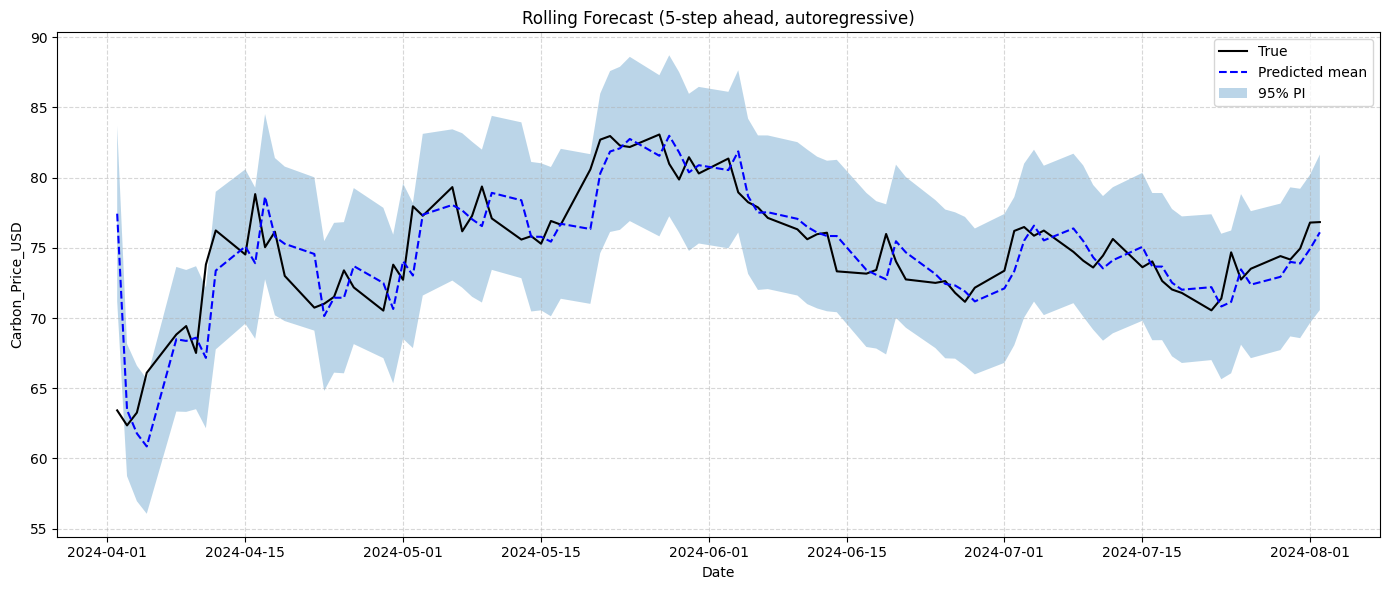

In [24]:
# ----------------------- #
# 8) Save results + plot rolling forecast
# ----------------------- #
metrics_df = pd.DataFrame([
    {"run": r["run"], "mpiw": r["mpiw"], "picp": r["picp"], "crps": r["crps"]}
    for r in all_runs
]).set_index("run")

print("\n==== Per-run metrics ====")
print(metrics_df.round(4))

summary = pd.DataFrame({
    "mean": metrics_df.mean(),
    "var": metrics_df.var(),
    "std": metrics_df.std()
}).round(4)
print("\n==== Summary ====")
print(summary)

# Average bounds across runs
avg_lower = np.mean(np.stack([r["lower"] for r in all_runs], axis=0), axis=0)
avg_upper = np.mean(np.stack([r["upper"] for r in all_runs], axis=0), axis=0)
avg_mean = np.mean(np.stack([r["mean"] for r in all_runs], axis=0), axis=0)

# Dates aligned to test set
rolling_dates = test_df[CFG.DATE_COLUMN].iloc[:len(avg_lower)].values

# Plot full rolling forecast (first horizon step only)
plt.figure(figsize=(14, 6))
plt.plot(test_df[CFG.DATE_COLUMN], y_true_inv, 'k-', label='True')
plt.plot(rolling_dates, (avg_lower[:, 0] + avg_upper[:, 0]) / 2,
         'b--', label='Predicted mean')
plt.fill_between(rolling_dates, avg_lower[:, 0], avg_upper[:, 0],
                 alpha=0.3, label='95% PI')
plt.title(f'Rolling Forecast ({CFG.FORECAST_HORIZON}-step ahead, autoregressive)')
plt.xlabel('Date')
plt.ylabel(CFG.TARGET_COLUMN)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("rnn_mdn_rolling_forecast.png", dpi=200)
plt.show()